
# Exercise 2
In a process for the production of metal laminates we collected 100 sequential measurements of laminate width (time series ‘A’ “Statistical Control by monitoring and feedback adjustment” Box Luceño – J. Wiley)


Identify and fit a model for the data.

<t1 style="color:red">
In a future class:
  
Design a SCC control chart and a FVC control chart  
</t1>


In [12]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

# Import the dataset
data = pd.read_csv('ESE4_ex2.csv')

# Inspect the dataset
data.head()

,EXE2
0,80
1,92
2,100
3,61
4,93


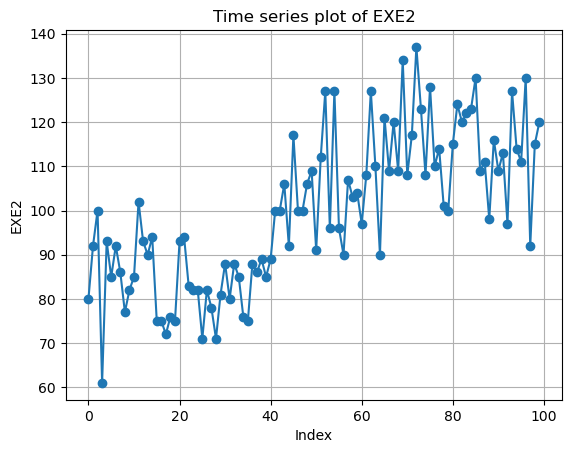

In [13]:
# Plot the data 
plt.plot(data['EXE2'], 'o-')
plt.xlabel('Index')
plt.ylabel('EXE2')
plt.title('Time series plot of EXE2')
plt.grid()
plt.show()

> let's verify the time dependence assumption with runs test and ACF/PACF

Runs test p-value = 0.000


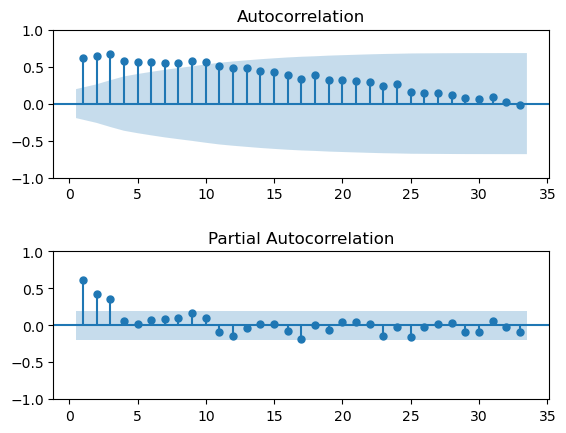

In [14]:
# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(data['EXE2'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['EXE2'], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['EXE2'], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

> The process is NON-STATIONARY.
>
> Let's try to apply the difference operator.

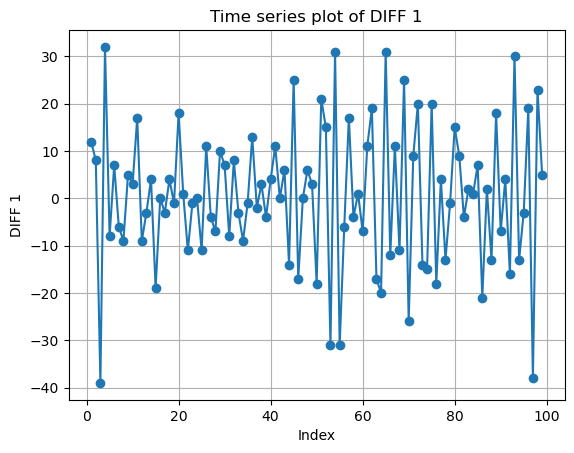

In [15]:
data['diff1'] = data['EXE2'].diff(1)

plt.plot(data['diff1'], 'o-')
plt.xlabel('Index')
plt.ylabel('DIFF 1')
plt.title('Time series plot of DIFF 1')
plt.grid()
plt.show()

> Let's verify again the time dependence assumption with runs test and ACF/PACF on the DIFF1 data

Runs test p-value = 0.000


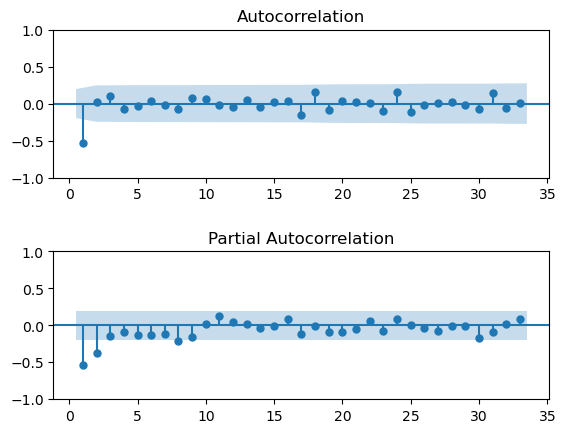

In [16]:
_, pval_runs = runstest_1samp(data['diff1'][1:], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['diff1'][1:], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['diff1'][1:], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

> After the differencing operation, the most suitable model seems to be an MA(1). Thus the investigated model is ARIMA(0,1,1)

In [17]:
# calculate an ARIMA model: import the necessary library
import qda

> The function `qda.ARIMA()` requires as inputs:
> 1. The dataframe with the data.
> 2. The `order` parameter, i.e., the $(p, d, q)$ of the model: $AR(p)$, $I(d)$, $MA(q)$.
> 3. The `add_constant` parameter, i.e. the presence of a constant term in the model:
>    - `False`, for no constant term.
>    - `True`, for a constant term.

In [18]:
# fit model ARIMA with constant term
x = data['EXE2']
model = qda.ARIMA(x, order=(0,1,1), add_constant = True) 

qda.ARIMAsummary(model)

---------------------
ARIMA MODEL RESULTS
---------------------
ARIMA model order: p=0, d=1, q=1

FINAL ESTIMATES OF PARAMETERS
-------------------------------
 Term    Coef  SE Coef  T-Value    P-Value
const  0.3111    0.226   1.3765 1.6867e-01
ma.L1 -0.8143    0.064 -12.7215 4.4928e-37

RESIDUAL SUM OF SQUARES
-------------------------
  DF         SS       MS
97.0 12318.5893 126.9958

Ljung-Box Chi-Square Statistics
----------------------------------
 Lag  Chi-Square  P-Value
  12      8.0673   0.7799
  24     14.9539   0.9221
  36     27.3625   0.8491
  48     39.2028   0.8133


> The calculated ARIMA model is in the form:
>
> $Y_t - Y_{t-1} = \nabla Y_t = \mu - \theta_{1}  \epsilon_{t-1} + \epsilon_t $
>
> The constant term ha a p-value of 0.169. Let's remove the constant value by omitting the `trend` parameter.

In [19]:
# fit model ARIMA with constant term
x = data['EXE2']
model = qda.ARIMA(x, order=(0,1,1), add_constant=False) # ARIMA(p,d,q), no constant term

qda.ARIMAsummary(model)

---------------------
ARIMA MODEL RESULTS
---------------------
ARIMA model order: p=0, d=1, q=1

FINAL ESTIMATES OF PARAMETERS
-------------------------------
 Term    Coef  SE Coef  T-Value    P-Value
ma.L1 -0.7854   0.0626 -12.5422 4.3837e-36

RESIDUAL SUM OF SQUARES
-------------------------
  DF        SS       MS
98.0 12528.408 127.8409

Ljung-Box Chi-Square Statistics
----------------------------------
 Lag  Chi-Square  P-Value
  12      8.5337   0.7422
  24     15.6625   0.8999
  36     27.8377   0.8329
  48     39.5483   0.8023


> The calculated ARIMA model is in the form:
>
> $Y_t - Y_{t-1} = \nabla Y_t = \theta_{1}  \epsilon_{t-1} + \epsilon_t $
>
> Let's check the assumptions on the residuals

Shapiro-Wilk test p-value = 0.643


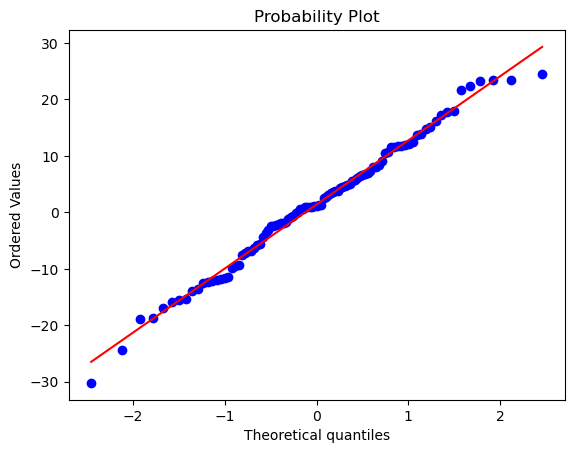

In [21]:
#extract the residuals
residuals = model.resid[1:]

# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(residuals)
print('Shapiro-Wilk test p-value = %.3f' % pval_SW)

# Plot the qqplot
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

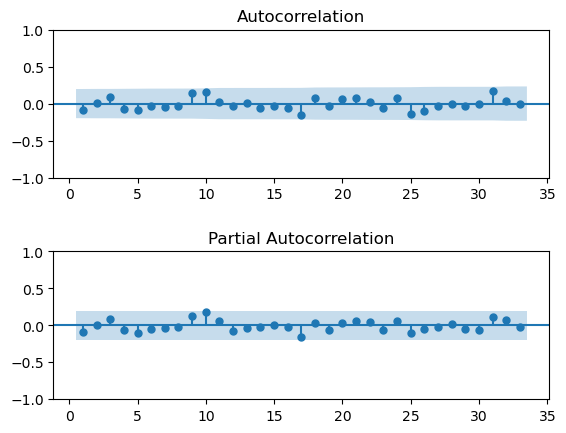

In [22]:
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(residuals, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(residuals, lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

Try at home: Bartlett test and LBQ test on ARIMA model residuals

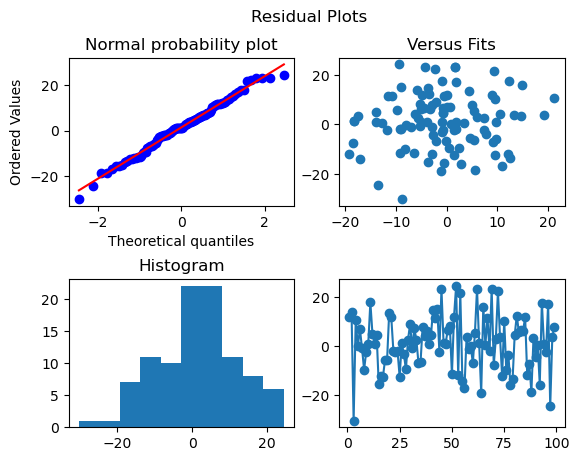

In [23]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(residuals, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(model.fittedvalues[1:], residuals)
axs[0,1].set_title('Versus Fits')
fig.subplots_adjust(hspace=0.5)
axs[1,0].hist(residuals)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(residuals)+1), residuals, 'o-')
plt.show()

> The model is adequate. 